# PROJECT MACHINE LEARNING : ECHOCARDIOGRAM DATA. 

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from scipy.stats import uniform
from scipy.stats import randint

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

#### We want to classifie if patients will survive for at least one year after a heart attack. 

- Survived = number of months patient survived (has survived, if patient is still alive). We have to pay attention because some patients (those who are still alive but had heart attack before 12 month ago)can not be used for prediction task mentionned above 


## Preparation of data set. 

In [2]:
data=pd.read_csv('cardio.txt', header=None, sep=',')
data.columns=['survival', 'still_alive', 'age', 'pericardial_effusion', 'fractionnal_shortening','epss','lvdd','wall_motion_score', 'wall_motion_index', 'mult', 'name','group','alive_at_1']
display(data)
data.info()

,survival,still_alive,age,pericardial_effusion,fractionnal_shortening,epss,lvdd,wall_motion_score,wall_motion_index,mult,name,group,alive_at_1
0,11,0,71,0,0.260,9,4.600,14,1,1,name,1,0
1,19,0,72,0,0.380,6,4.100,14,1.700,0.588,name,1,0
2,16,0,55,0,0.260,4,3.420,14,1,1,name,1,0
3,57,0,60,0,0.253,12.062,4.603,16,1.450,0.788,name,1,0
4,19,1,57,0,0.160,22,5.750,18,2.250,0.571,name,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,7.5,1,64,0,0.24,12.9,4.72,12,1,0.857,name,?,?
128,41,0,64,0,0.28,5.40,5.47,11,1.10,0.714,name,?,?
129,36,0,69,0,0.20,7.00,5.05,14.5,1.21,0.857,name,?,?
130,22,0,57,0,0.14,16.1,4.36,15,1.36,0.786,name,?,?


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   survival                132 non-null    object
 1   still_alive             132 non-null    object
 2   age                     132 non-null    object
 3   pericardial_effusion    132 non-null    object
 4   fractionnal_shortening  132 non-null    object
 5   epss                    132 non-null    object
 6   lvdd                    132 non-null    object
 7   wall_motion_score       132 non-null    object
 8   wall_motion_index       132 non-null    object
 9   mult                    132 non-null    object
 10  name                    132 non-null    object
 11  group                   132 non-null    object
 12  alive_at_1              132 non-null    object
dtypes: object(13)
memory usage: 13.5+ KB


- As we read it on description data, we will use wall_motion_index instead of wall_motion_score. And we will ignore mult, name and group features. 
- We also change '?' by Nan.
- We change type to float of every column

In [3]:
data=data.drop(['wall_motion_score', 'mult', 'name','group'], axis=1)
data=data.replace('?', np.NaN)
data=data.astype('float')
display(data)

,survival,still_alive,age,pericardial_effusion,fractionnal_shortening,epss,lvdd,wall_motion_index,alive_at_1
0,11.0,0.0,71.0,0.0,0.260,9.000,4.600,1.000,0.0
1,19.0,0.0,72.0,0.0,0.380,6.000,4.100,1.700,0.0
2,16.0,0.0,55.0,0.0,0.260,4.000,3.420,1.000,0.0
3,57.0,0.0,60.0,0.0,0.253,12.062,4.603,1.450,0.0
4,19.0,1.0,57.0,0.0,0.160,22.000,5.750,2.250,0.0
...,...,...,...,...,...,...,...,...,...
127,7.5,1.0,64.0,0.0,0.240,12.900,4.720,1.000,NaN
128,41.0,0.0,64.0,0.0,0.280,5.400,5.470,1.100,NaN
129,36.0,0.0,69.0,0.0,0.200,7.000,5.050,1.210,NaN
130,22.0,0.0,57.0,0.0,0.140,16.100,4.360,1.360,NaN


- Remove data of patient that we can not use for prediction task (those who had a heart attack less than 12 months ago and are still alive).

In [4]:
line=data[ (data['survival']<=12)&((data['alive_at_1']==1) | (data['still_alive']==1))].index
data=data.drop(line, axis=0)
#display(data)
data[ (data['survival']<=12)&(data['alive_at_1']==1)].index

Int64Index([], dtype='int64')

How many are missing values ? 

In [5]:
def missing_values (data) : 
    nb=data.isnull().sum()[data.isnull().sum()>0]
    freq=nb/len(data)
    df=pd.concat((nb, freq), axis=1)
    df.columns=['Number', 'Frequence']
    return(df)

In [6]:
missing_values(data)

,Number,Frequence
survival,2,0.020408
still_alive,1,0.010204
age,3,0.030612
pericardial_effusion,1,0.010204
fractionnal_shortening,4,0.040816
epss,10,0.102041
lvdd,5,0.051020
alive_at_1,47,0.479592


What strategie to fill missing values of the target? 

We can adopt a logical strategy to complet alive_at_1 (the target) with still_alive and survival: 
- if survival >=12 so alive_at_1 =1
- if survival<12 and still_alive=0 so alive_at_1=0

In [7]:
data[data.alive_at_1.isnull()]

,survival,still_alive,age,pericardial_effusion,fractionnal_shortening,epss,lvdd,wall_motion_index,alive_at_1
24,48.0,0.0,64.0,0.0,0.190,5.90,3.48,1.110,NaN
25,29.0,0.0,54.0,0.0,0.300,7.00,3.85,1.667,NaN
26,29.0,0.0,35.0,0.0,0.300,5.00,4.17,1.000,NaN
27,29.0,0.0,55.0,0.0,NaN,7.00,NaN,1.000,NaN
33,27.0,0.0,47.0,0.0,0.400,5.12,3.10,1.000,NaN
39,31.0,0.0,80.0,0.0,0.410,5.40,4.36,1.000,NaN
45,37.0,0.0,64.0,0.0,0.090,NaN,NaN,2.000,NaN
49,NaN,NaN,77.0,NaN,NaN,NaN,NaN,2.000,NaN
52,10.0,0.0,57.0,0.0,0.240,14.80,5.26,1.380,NaN
59,38.0,0.0,68.0,0.0,0.290,NaN,4.41,1.167,NaN


We can delete line 49 because we only have age and wall_motion_index of the patient. 

In [8]:
data=data.drop(49, axis=0)
missing_values(data)

,Number,Frequence
survival,1,0.010309
age,3,0.030928
fractionnal_shortening,3,0.030928
epss,9,0.092784
lvdd,4,0.041237
alive_at_1,46,0.474227


In [9]:
data.loc[data[(data['survival']>=12) & (data.alive_at_1.isnull())].index , 'alive_at_1']=1

In [10]:
data[data.alive_at_1.isnull()]

,survival,still_alive,age,pericardial_effusion,fractionnal_shortening,epss,lvdd,wall_motion_index,alive_at_1
52,10.0,0.0,57.0,0.0,0.24,14.8,5.26,1.38,NaN
61,9.0,0.0,73.0,0.0,0.12,NaN,6.78,1.39,NaN


We can complete 'alive_at_1' using the second method described above. 

In [11]:
data.loc[data[(data['survival']<12) & (data['still_alive']==0) & (data.alive_at_1.isnull())].index , 'alive_at_1']=0

In [12]:
display(missing_values(data), data)

,Number,Frequence
survival,1,0.010309
age,3,0.030928
fractionnal_shortening,3,0.030928
epss,9,0.092784
lvdd,4,0.041237


,survival,still_alive,age,pericardial_effusion,fractionnal_shortening,epss,lvdd,wall_motion_index,alive_at_1
0,11.0,0.0,71.0,0.0,0.260,9.000,4.600,1.000,0.0
1,19.0,0.0,72.0,0.0,0.380,6.000,4.100,1.700,0.0
2,16.0,0.0,55.0,0.0,0.260,4.000,3.420,1.000,0.0
3,57.0,0.0,60.0,0.0,0.253,12.062,4.603,1.450,0.0
4,19.0,1.0,57.0,0.0,0.160,22.000,5.750,2.250,0.0
...,...,...,...,...,...,...,...,...,...
126,21.0,0.0,61.0,0.0,0.140,25.500,5.160,1.270,1.0
128,41.0,0.0,64.0,0.0,0.280,5.400,5.470,1.100,1.0
129,36.0,0.0,69.0,0.0,0.200,7.000,5.050,1.210,1.0
130,22.0,0.0,57.0,0.0,0.140,16.100,4.360,1.360,1.0


We separe our data in a test and train sample and we will use test sample when we find our model to evaluate it. 

In [55]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['survival', 'still_alive', 'alive_at_1'], axis=1), 
                                                    data.alive_at_1, random_state=1234, test_size=0.2)

Here, we are in a supervised classification. We are going to use accuracy for scoring metric.

In [56]:
missing_values(X_train), X_train.shape

(                        Number  Frequence
 age                          1   0.012987
 fractionnal_shortening       3   0.038961
 epss                         8   0.103896
 lvdd                         4   0.051948,
 (77, 6))

### Data visualization. 

In [57]:
display(X_train)

,age,pericardial_effusion,fractionnal_shortening,epss,lvdd,wall_motion_index
56,63.0,0.0,0.15,13.0,4.57,1.080
4,57.0,0.0,0.16,22.0,5.75,2.250
11,62.0,1.0,0.45,9.0,3.60,1.140
97,59.0,0.0,0.50,9.1,3.42,1.500
67,70.0,1.0,0.25,9.7,5.57,1.100
...,...,...,...,...,...,...
110,62.0,0.0,0.22,12.1,3.92,1.000
78,64.0,0.0,0.20,7.1,4.58,1.000
58,70.0,0.0,0.10,9.8,5.30,2.300
117,54.0,0.0,0.43,9.3,4.79,1.000


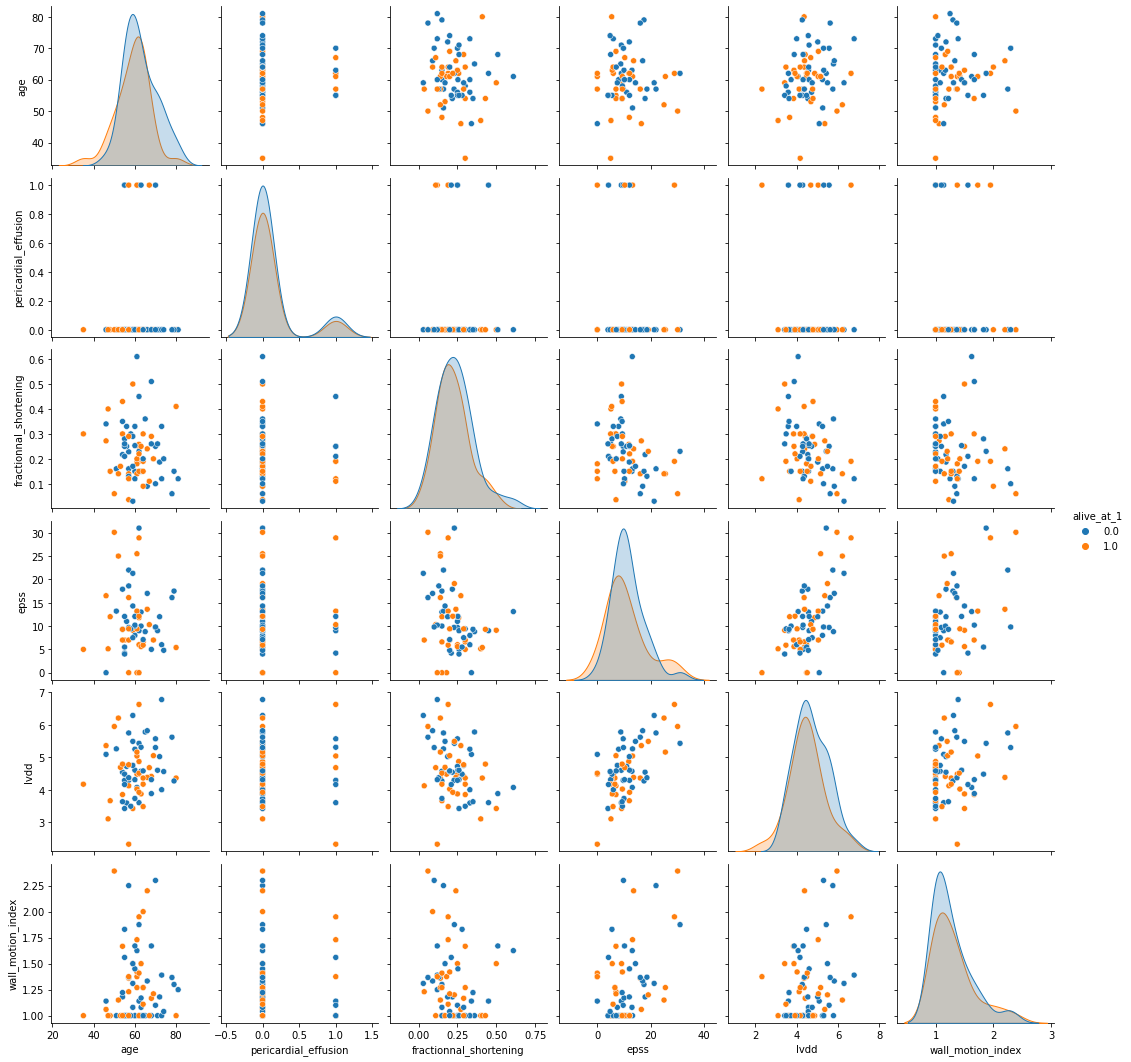

In [58]:
df=pd.concat((X_train, y_train), axis=1)
sns.pairplot(df, hue='alive_at_1')
plt.show()

In [60]:
target_balance=pd.concat((y_train.value_counts(), y_train.value_counts()/len(y_train)), axis=1)
target_balance.columns=['Numbers', 'Frequence']
display(target_balance)

,Numbers,Frequence
0.0,42,0.545455
1.0,35,0.454545


##### Here we have balanced data, but cost sensitive data. More over, we constat that we have less positive than negativ and we want to correctly predict that the patient will NOT survive (negative). So, we have to minimze the number of False Positive. For this purpose, we want to maximize precision score. We have a trade-off with the recall score. 

In [70]:
new_target= y_train*(-1) +1
target_balance=pd.concat((new_target.value_counts(), new_target.value_counts()/len(new_target)), axis=1)
target_balance.columns=['Numbers', 'Frequence']
display(target_balance)

,Numbers,Frequence
1.0,42,0.545455
0.0,35,0.454545


With new target, we have invert target values and 0 = Alive at 1 and 1= not alive at 1. et ainsi on va pouvoir utiliser le roc_auc score. 

In [72]:
y_train = new_target

In [73]:
# Logistic regression avec Gridsearch

clf=LogisticRegression(solver='saga', max_iter=10**6)
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), clf)

distribution = dict(logisticregression__C=uniform(loc=0, scale=4),
                    logisticregression__penalty=['l2', 'l1' ], 
                    simpleimputer__strategy= ['mean', 'median'])

grid_search=RandomizedSearchCV(pipe, distribution, n_iter=5, cv=50, scoring='roc_auc', return_train_score=True, random_state=12346)
grid_search.fit(X_train,y_train)
display(grid_search.best_params_)
print('ROC AUC score  is {} +/- {}.'.format(grid_search.cv_results_['mean_test_score'].max(), 
                                      grid_search.cv_results_['std_test_score'][grid_search.cv_results_['mean_test_score'].argmax()]))

{'logisticregression__C': 1.038395802955228,
 'logisticregression__penalty': 'l1',
 'simpleimputer__strategy': 'mean'}

ROC AUC score  is 0.5983333333333334 +/- 0.1847314116344171.


In [17]:
clf=SVC(C=0.0001, degree=10,kernel='linear')
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN, strategy='median'), clf)
cv=cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
print('Accuracy is {} +/- {}.'.format(cv.mean(), cv.std()))

Accuracy is 0.5449999999999999 +/- 0.01428869016623521.


In [74]:
#Random Forest with StandardScaler and Gridsearch 

clf=RandomForestClassifier()
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)

distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  randomforestclassifier__bootstrap=[True, False], 
                  randomforestclassifier__n_estimators=randint(20,800))
                  

grid_search=RandomizedSearchCV(pipe, distribution, n_iter=25, cv=10, scoring='roc_auc', return_train_score=True, random_state=12346)
grid_search.fit(X_train,y_train)
display(grid_search.best_params_)
print('Accuracy is {} +/- {}.'. format(grid_search.cv_results_['mean_test_score'].max(), 
                                 grid_search.cv_results_['std_test_score'][grid_search.cv_results_['mean_test_score'].argmax()]))

{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__n_estimators': 286,
 'simpleimputer__strategy': 'median'}

Accuracy is 0.5195833333333333 +/- 0.20955516709343044.


In [48]:
#Random Forest with Gridsearch 

clf=RandomForestClassifier()
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), clf)

distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  randomforestclassifier__bootstrap=[True, False], 
                  randomforestclassifier__n_estimators=randint(20,800))
                  

grid_search=RandomizedSearchCV(pipe, distribution, n_iter=25, cv=10, scoring='roc_auc', return_train_score=True, random_state=12346)
grid_search.fit(X_train,y_train)
display(grid_search.best_params_)
print('Accuracy is {} +/- {}.'. format(grid_search.cv_results_['mean_test_score'].max(), 
                                       grid_search.cv_results_['std_test_score'][grid_search.cv_results_['mean_test_score'].argmax()]))

{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__n_estimators': 31,
 'simpleimputer__strategy': 'mean'}

Accuracy is 0.5446428571428571 +/- 0.15776055545396275.


In [75]:
# K-nearest neighbors

clf=KNeighborsClassifier()
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), clf)
pipe.get_params()

{'memory': None,
 'steps': [('simpleimputer', SimpleImputer()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'simpleimputer': SimpleImputer(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'simpleimputer__add_indicator': False,
 'simpleimputer__copy': True,
 'simpleimputer__fill_value': None,
 'simpleimputer__missing_values': nan,
 'simpleimputer__strategy': 'mean',
 'simpleimputer__verbose': 0,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

In [77]:
distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  kneighborsclassifier__weights=['uniform', 'distance'], 
                  kneighborsclassifier__n_neighbors= randint(1, 50))

grid_search=RandomizedSearchCV(pipe, distribution, n_iter=100, cv=10, scoring='roc_auc', return_train_score=True, random_state=12346)
grid_search.fit(X_train,y_train)
display(grid_search.best_params_)
print('Roc_auc score is {} +/- {}.'. format(grid_search.cv_results_['mean_test_score'].max(), grid_search.cv_results_['std_test_score'][grid_search.cv_results_['mean_test_score'].argmax()]))     
                                                                                 

{'kneighborsclassifier__n_neighbors': 23,
 'kneighborsclassifier__weights': 'distance',
 'simpleimputer__strategy': 'median'}

Roc_auc score is 0.6241666666666668 +/- 0.1612752994795614.


### Training cost-sensitive Neural Networks